# Testing the effects of bad task descriptions

In [92]:
import os
import json
import textwrap
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.transforms as transforms
import matplotlib.transforms as mpl_transforms

from my_code.utils import load_nested_dict_to_pandas
from my_code.plotting import graph_theme

In [2]:
width = 7.1413/0.75
colwidth = 3.433071
linewidth = 7.12598

In [3]:
RESULTS_PATH = "./results/elicitation/varied_descriptions"

In [4]:
results_files = [f for f in os.listdir(RESULTS_PATH) if f.endswith(".json")]
print("Loading files: ", "\n", "\n ".join(results_files))
results_dicts = [
    json.load(open(os.path.join(RESULTS_PATH, f), "r"))
    for f in results_files
]

Loading files:  
 prior_no_prior_results_fake_data_three_feature_relationship_2.json
 prior_no_prior_results_fake_data_one_feature_relationship_7.json
 prior_no_prior_results_fake_data_uninformative_7.json
 prior_no_prior_results_fake_data_little_information_9.json
 prior_no_prior_results_fake_data_adverserial_9.json
 prior_no_prior_results_fake_data_equation_feature_relationship_5.json
 prior_no_prior_results_fake_data_little_information_5.json
 prior_no_prior_results_fake_data_adverserial_5.json
 prior_no_prior_results_fake_data_two_feature_relationship_0.json
 prior_no_prior_results_fake_data_equation_feature_relationship_9.json
 prior_no_prior_results_fake_data_equation_feature_relationship_8.json
 prior_no_prior_results_fake_data_adverserial_4.json
 prior_no_prior_results_fake_data_two_feature_relationship_1.json
 prior_no_prior_results_fake_data_little_information_4.json
 prior_no_prior_results_fake_data_equation_feature_relationship_4.json
 prior_no_prior_results_fake_data_adver

In [5]:
results_dfs = [
    load_nested_dict_to_pandas(
        results_dict, 
        level_names=[
            "dataset", "description_type", "run", "n_data_points_seen", "prior_type"
        ]
    ).assign(results_file_name=results_file_name)
    
    for results_dict, results_file_name in zip(results_dicts, results_files)
]

results_df = pd.concat(
    results_dfs
).astype(
    {
        "n_data_points_seen": int,
    }
)

In [6]:
dataset_metric_to_plot = {
    "fake_data": "mse",
}

dataset_rename = {
    "fake_data": r"$y = 2 x_1 - x_2 + x_3$",
}


metric_results = (
    results_df
    # get the correct metric for each dataset
    .assign(
        metrics_to_plot=lambda df: (
            df.apply(
                lambda row: row[dataset_metric_to_plot[row["dataset"]]],
                axis=1
            )
        )
    )
    .assign(
        metrics_to_plot=lambda x: x["metrics_to_plot"].apply(
            lambda x: np.array(x).reshape(-1)),
    )
    .set_index(["dataset", "description_type", "n_data_points_seen", "prior_type", "run"])
    [["metrics_to_plot"]]
    .assign(sample=lambda x: x["metrics_to_plot"].apply(lambda x: np.arange(len(x))))
    .explode(["metrics_to_plot", "sample"])
    .set_index("sample", append=True)
    .reset_index()
    .reset_index(drop=True)
    .replace({"dataset": dataset_rename})
)

In [7]:
metric_results_line_plot = (
    metric_results
    .loc[lambda df: df["n_data_points_seen"].isin([5, 10, 20, 30])]
    .groupby(["dataset", "n_data_points_seen", "description_type", "run"])
    [["metrics_to_plot"]]
    .mean()
    .reset_index()
)


(['xkcd:bright orange',
  (0.94291042, 0.37549479, 0.26369821),
  (0.7965014, 0.10506637, 0.31063031),
  (0.51728314, 0.1179558, 0.35453252),
  (0.24525608, 0.10497384, 0.26395596),
  'xkcd:bright blue'],)

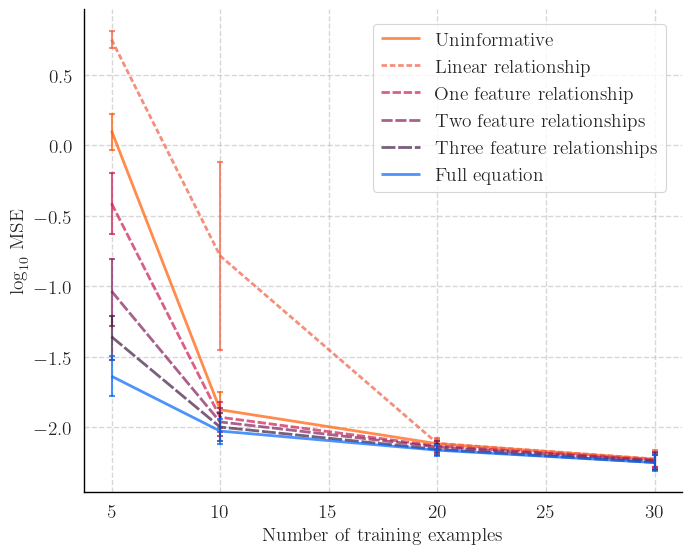

In [63]:
description_nice_names = {
    "adverserial": "Adverserial",
    "uninformative": "Uninformative",
    "little_information": "Linear relationship",
    "one_feature_relationship": "One feature relationship",
    "two_feature_relationship": "Two feature relationships",
    "three_feature_relationship": "Three feature relationships",
    "equation_feature_relationship": "Full equation",
}

description_order = [
    "Uninformative",
    "Linear relationship",
    "One feature relationship",
    "Two feature relationships",
    "Three feature relationships",
    "Full equation",
]

description_colour = {
    "Uninformative": "xkcd:bright orange",
    "Linear relationship": (0.94291042, 0.37549479, 0.26369821),
    "One feature relationship": (0.7965014, 0.10506637, 0.31063031),
    "Two feature relationships": (0.51728314, 0.1179558, 0.35453252),
    "Three feature relationships": (0.24525608, 0.10497384, 0.26395596),
    "Full equation": 'xkcd:bright blue',
}


fontsize=14

dataset = r"$y = 2 x_1 - x_2 + x_3$"

with graph_theme():
    plt.close()

    fig, ax = plt.subplots(
        1, 1, 
        figsize=(2*colwidth, 2*0.8*colwidth)
    )

    ax = sns.lineplot(
        data=(
            metric_results_line_plot
            .query("dataset == @dataset")
            .assign(
                metrics_to_plot=lambda x: 
                np.log10(x["metrics_to_plot"].astype(float)) 
            )
            .replace({"description_type": description_nice_names})
            .loc[lambda x : x["description_type"].isin(description_order)]
        ),
        x="n_data_points_seen",
        y="metrics_to_plot",
        hue="description_type",
        hue_order=description_order,
        style="description_type",
        markers=False,
        style_order=description_order[::-1],
        alpha=0.7,
        err_style="bars",
        errorbar=("ci", 95),
        err_kws=dict(
            capsize=2,
            capthick=1.5,
            elinewidth=1.5,
            linewidth=1.5,
        ),
        dashes=[
            (1, 0),
            (5, 1),
            (4, 1),
            (3, 1),
            (2, 1),
            (1, 0),
        ],
        markersize=7,
        linewidth=2,
        ax=ax,
        legend=True,
        palette=description_colour,
    )

    ax.set_ylabel(r"$\log_{10}$ MSE", fontsize=fontsize)
    ax.set_xlabel("Number of training examples", fontsize=fontsize)
    ax.tick_params(axis="both", labelsize=fontsize)
    ax.set_title("", fontsize=fontsize)

    sns.move_legend(
        ax,
        "upper right",
        bbox_to_anchor=(0.99, 0.99),
        fontsize=fontsize,
        title="",
    )

    fig.subplots_adjust(
        wspace=0.35,
        left=0.12,
        right=0.99,
        top=0.98,
        bottom=0.1,
    )

    fig.savefig(
        "./results/elicitation_varied_descriptions_results_lineplot.pdf",
    )
    fig.savefig(
        "./results/elicitation_varied_descriptions_results_lineplot.svg",
    )

    plt.show()

## Looking at some of the priors:

In [15]:
PRIORS_DIR = Path("./priors/elicitation/varied_descriptions")

prior_files = [
    f
    for f in os.listdir(PRIORS_DIR)
    if f.startswith(f"fake_data_little_information")
]
priors = []
for prior_file in prior_files:
    prior = np.load(os.path.join(PRIORS_DIR, prior_file))
    priors.append(prior)

priors = np.stack(priors)

In [16]:
priors.mean(axis=0).round(2).astype(str)

array([['0.0', '1.0'],
       ['0.5', '0.12'],
       ['-0.32', '0.08'],
       ['0.56', '0.14']], dtype='<U32')

In [17]:
priors.std(axis=0).round(2).astype(str)

array([['0.0', '0.0'],
       ['0.11', '0.05'],
       ['0.08', '0.06'],
       ['0.26', '0.09']], dtype='<U32')

## What do the priors look like for the task descriptions?

In [34]:
import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [35]:
PRIORS_DIR = Path("./priors/elicitation/varied_descriptions")

prior_files = [
    f
    for f in os.listdir(PRIORS_DIR)
]

prior_types = {f.split("fake_data_")[1].split("_prior")[0] for f in  prior_files}

priors_dict = {pt: [] for pt in prior_types}
for prior_file in prior_files:
    prior = np.load(os.path.join(PRIORS_DIR, prior_file))
    prior_type = prior_file.split("fake_data_")[1].split("_prior")[0]
    priors_dict[prior_type].append(prior)

priors_dict = {pt: np.stack(priors_dict[pt]) for pt in prior_types}

In [36]:
# sampling prior parameters

prior_samples_dict = {}
for prior_type, priors in priors_dict.items():
    n_priors, n_features, _ = priors.shape
    with pm.Model() as model:

        w = pm.Dirichlet(
            'w', a=np.ones(n_priors), shape=(n_features, n_priors)
        )

        components = pm.Normal.dist(
            mu=priors[:, :, 0].T,
            sigma=priors[:, :, 1].T,
            shape=(n_features, n_priors)
        )

        theta = pm.Mixture(
            "theta",
            w=w,
            comp_dists=components,
        )

        prior_samples_pe = pm.sample_prior_predictive(samples=10000)

    prior_samples_pe = (
        prior_samples_pe['prior']['theta']
        .to_numpy().squeeze()
    )

    prior_samples_dict[prior_type] = prior_samples_pe

Sampling: [theta, w]
Sampling: [theta, w]
Sampling: [theta, w]
Sampling: [theta, w]
Sampling: [theta, w]
Sampling: [theta, w]


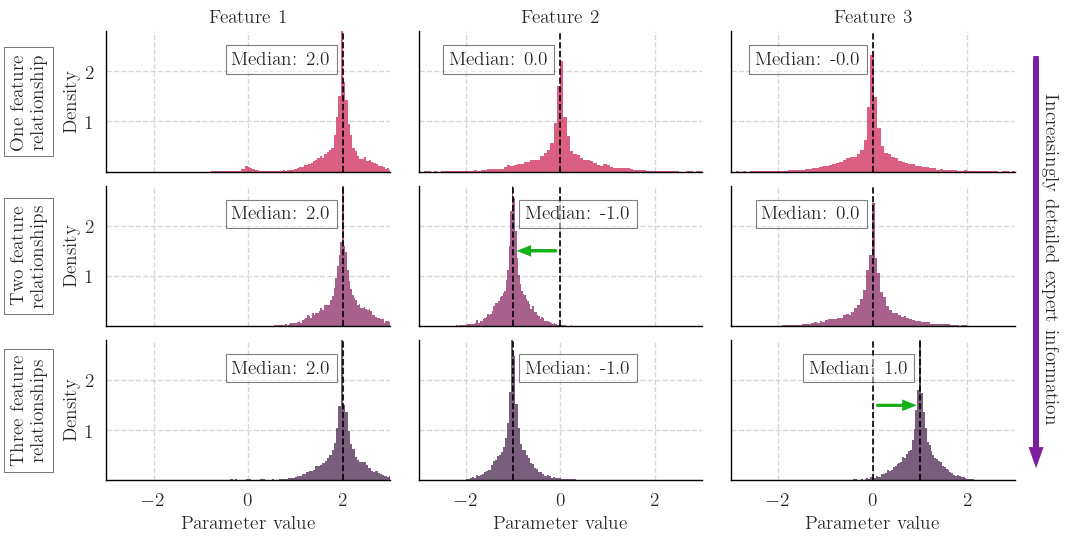

In [165]:
prior_types_to_plot = [
    "one_feature_relationship",
    "two_feature_relationship",
    "three_feature_relationship",
]

description_colour = {
    "one_feature_relationship": (0.7965014, 0.10506637, 0.31063031),
    "two_feature_relationship": (0.51728314, 0.1179558, 0.35453252),
    "three_feature_relationship": (0.24525608, 0.10497384, 0.26395596),
}

description_nice_names = {
    "one_feature_relationship": "One feature relationship",
    "two_feature_relationship": "Two feature relationships",
    "three_feature_relationship": "Three feature relationships",
}


fontsize = 14
alpha = 0.7
hist_config = dict(
    alpha = alpha,
    bins=100,
    edgecolor = "black",
    linewidth = 0.0,
    stat = "density",
)

with graph_theme():
    plt.close()
    fig = plt.figure(
        figsize=(1.5*linewidth, 0.6*2*linewidth/1.618)
    )
    for prior_i, prior_type in enumerate(prior_types_to_plot):
        prior_samples_pe = prior_samples_dict[prior_type]
        
        for feature in range(n_features-1):

            ax = fig.add_subplot(
                len(prior_types_to_plot), 
                (n_features-1), 
                feature+1 + prior_i*len(prior_types_to_plot)
            )

            sns.histplot(
                prior_samples_pe[:, feature + 1], 
                color=description_colour[prior_type],
                ax=ax,
                **hist_config
            )

            if prior_i == 0:
                ax.set_title(f"Feature {feature + 1}", fontsize=fontsize)
            if feature == 0:
                ax.set_ylabel("Density", fontsize=fontsize)
                ax.set_yticks([1,2,3])
                ax.set_yticklabels([1,2,""])
            else:
                ax.set_ylabel("", fontsize=fontsize)
                ax.set_yticks([1,2,3])
                ax.set_yticklabels([])


            if prior_i == len(prior_types_to_plot) - 1:
                ax.set_xlabel(f"Parameter value", fontsize=fontsize)
                ax.set_xticks([-2, 0, 2])
            else:
                ax.set_xlabel("", fontsize=fontsize)
                ax.set_xticks([-2, 0, 2])
                ax.set_xticklabels([])

            ax.tick_params(axis="both", labelsize=fontsize)

            ax.set_xlim(-3, 3)
            ax.set_ylim(0, 2.8)


            median_param_value = np.median(prior_samples_pe[:, feature+1])

            ax.axvline(
                x=median_param_value, 
                linestyle="--", 
                color="xkcd:black",
            )

            trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)

            if median_param_value > -0.5:
                ax.text(
                    median_param_value-0.25, 0.8, 
                    f"Median: {median_param_value:.1f}",
                    fontsize=fontsize,
                    transform=trans,
                    verticalalignment='center',
                    horizontalalignment='right',
                    bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'),
                )
            else:
                ax.text(
                    median_param_value+0.25, 0.8, 
                    f"Median: {median_param_value:.1f}",
                    fontsize=fontsize,
                    transform=trans,
                    verticalalignment='center',
                    horizontalalignment='left',
                    bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'),
                )
            
            if feature == 0:
                trans = mpl_transforms.blended_transform_factory(
                    fig.transFigure, ax.transAxes
                )
                fig.text(
                    0.01, 0.5,
                    '\n'.join(textwrap.wrap(description_nice_names[prior_type], 20)),
                    horizontalalignment='left',
                    verticalalignment='center',
                    transform=trans,
                    fontsize=fontsize,
                    rotation=90,
                    multialignment="center",
                    bbox=dict(
                        facecolor='white', 
                        alpha=0.75, 
                        edgecolor='black',
                        linewidth=0.5
                    ),
                )

            if prior_i == 1 and feature == 1:
                ax.axvline(
                    0, linestyle="--", color="xkcd:black"
                )
                ax.arrow(
                    -0.1, 1.5, -0.75, 0,
                    head_width=0.15,
                    head_length=0.2,
                    linewidth=2,
                    fc='xkcd:green',
                    ec='xkcd:green',
                    length_includes_head=True,
                )

            if prior_i == 2 and feature == 2:
                ax.axvline(
                    0, linestyle="--", color="xkcd:black"
                )
                ax.arrow(
                    0.1, 1.5, 0.75, 0,
                    head_width=0.15,
                    head_length=0.2,
                    linewidth=2,
                    fc='xkcd:green',
                    ec='xkcd:green',
                    length_includes_head=True,
                )

            if prior_i == 0 and feature == 2:
                ax.arrow(
                    3.45, 2.25, 0.0, -8,
                    head_width=0.15,
                    head_length=0.2,
                    linewidth=4,
                    fc='xkcd:purple',
                    ec='xkcd:purple',
                    length_includes_head=True,
                    clip_on=False,
                )
                ax.text(
                    3.75, 2.75-4.5, 
                    "Increasingly detailed expert information",
                    fontsize=fontsize,
                    verticalalignment='center',
                    horizontalalignment='center',
                    rotation=270,
                )


    fig.subplots_adjust(
        wspace=0.1,
        hspace=0.1,
        top=0.95,
        bottom=0.1,
        left=0.1,
        right=0.95,
    )

    fig.savefig(
        "./results/elicitation_varied_descriptions_prior_parameter_distribution.pdf",
    )

    plt.show()
